# Overfitting on the IMDB movie reviews dataset

In this notebook we shall focus on overfitting, demonstrating the phenomenon and studying techniques to address it. The dataset we shall use is the IMDB movie reviews dataset, composed of 25,000 movies reviews, labeled by sentiment (positive/negative).

To prevent overfitting, the best solution is to use more training data. When that is not a viable possibility, you can try to use regularization techniques, constraining the quantity and quality of information stored by the model. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent ones, which have a better chance of generalizing well.



In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np

Let us load the dataset. In keras, the dataset is preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data.

In [14]:
num_words = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz", num_words=num_words)

Let us a look at the encoding of the first review.



In [15]:
print(x_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


This representation has a variable length dimension, that is not very stuitable for a neural network.

Let us transform it into a multi_hot encoding of of dimension equal to num_words. In this representation, a word gets index 1 if it appears in the document. It is essentially a bag-of-words encoding.

"this film is very bad" -> 0
"this film is not so bad" -> 1




In [16]:
def multi_hot_sequences(sequences, dimension):
  multi_hot = np.zeros((len(sequences),dimension))
  for i in range(0,len(sequences)):
    multi_hot[i, sequences[i]] = 1
  return multi_hot


x_train = multi_hot_sequences(x_train, num_words)
x_test = multi_hot_sequences(x_test, num_words)

Let us have a look at the initial part of the encoding for the first review.

In [37]:
print(x_train[0,0:30])

print( x_test.shape)

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0.]
(25000, 500)


We now define our first model, that is just a concatenation of three dense layers.

In [30]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu')(seq)
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

base_model = Model(seq, x)

In [31]:
base_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,121 (129.38 KB)

 Trainable params: 33,121 (129.38 KB)

 Non-trainable params: 0 (0.00 B)

We compile the model using adam as optimizer, and binary crossentropy (log likelyhood) as loss function. The fit function returns a history of the training, that can be later inspected. In addition to the loss function, that is the canonical metric used for training, we also ask the model to keep trace of accuracy.

In [32]:
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
base_history = base_model.fit(
    x_train,
    y_train,
    epochs = 6,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 1
)

Epoch 1/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6127 - loss: 0.6442 - val_accuracy: 0.8028 - val_loss: 0.4390
Epoch 2/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8205 - loss: 0.4042 - val_accuracy: 0.8282 - val_loss: 0.3932
Epoch 3/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8400 - loss: 0.3623 - val_accuracy: 0.8310 - val_loss: 0.3863
Epoch 4/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8450 - loss: 0.3595 - val_accuracy: 0.8306 - val_loss: 0.3844
Epoch 5/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8515 - loss: 0.3481 - val_accuracy: 0.8301 - val_loss: 0.3848
Epoch 6/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8610 - loss: 0.3251 - val_accuracy: 0.8296 - val_loss: 0.3840


Let us see the keys available in our history.

In [28]:
print(base_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


The following function allows us to plot the results.

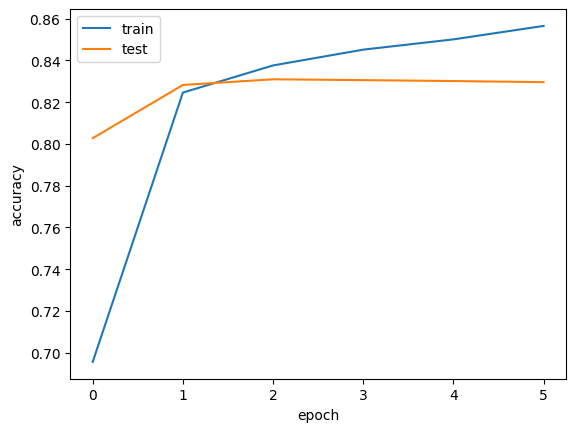

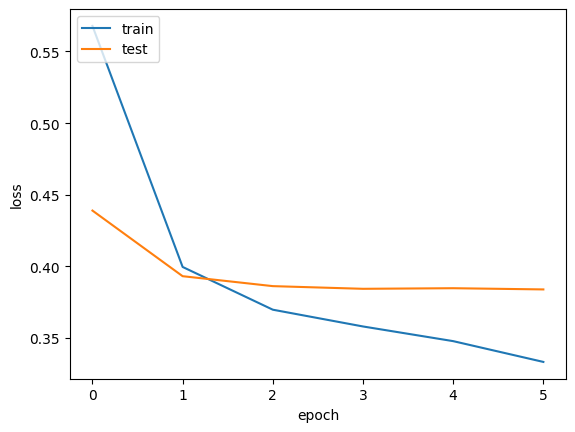

In [34]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(base_history,['accuracy','val_accuracy'])
plot_history(base_history,['loss','val_loss'])


# Weight regularization

Now we modify our base model adding regularizers.

A common way to mitigate overfitting is to reduce the complexity of the network by forcing its weights to only take small values, making the distribution of weights more “regular”. This is called “weight regularization”, and it is done by adding to the loss function of the network an additional cost associated with having large weights.

In [39]:
from keras import regularizers

seq = Input(shape=(num_words,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(seq)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dense(1, activation='sigmoid')(x)

l2reg_model = Model(seq, x)

In [40]:
l2reg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
l2reg_history = l2reg_model.fit(
    x_train,
    y_train,
    epochs = 15,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 2
)

Epoch 1/15
49/49 - 1s - 17ms/step - accuracy: 0.8349 - loss: 0.4644 - val_accuracy: 0.8312 - val_loss: 0.4667
Epoch 2/15
49/49 - 1s - 19ms/step - accuracy: 0.8362 - loss: 0.4544 - val_accuracy: 0.8322 - val_loss: 0.4570
Epoch 3/15
49/49 - 1s - 15ms/step - accuracy: 0.8337 - loss: 0.4488 - val_accuracy: 0.8322 - val_loss: 0.4506
Epoch 4/15
49/49 - 1s - 13ms/step - accuracy: 0.8365 - loss: 0.4390 - val_accuracy: 0.8326 - val_loss: 0.4469
Epoch 5/15
49/49 - 1s - 12ms/step - accuracy: 0.8393 - loss: 0.4327 - val_accuracy: 0.8330 - val_loss: 0.4407
Epoch 6/15
49/49 - 1s - 12ms/step - accuracy: 0.8351 - loss: 0.4318 - val_accuracy: 0.8330 - val_loss: 0.4371
Epoch 7/15
49/49 - 1s - 15ms/step - accuracy: 0.8362 - loss: 0.4287 - val_accuracy: 0.8258 - val_loss: 0.4461
Epoch 8/15
49/49 - 1s - 28ms/step - accuracy: 0.8380 - loss: 0.4217 - val_accuracy: 0.8337 - val_loss: 0.4312
Epoch 9/15
49/49 - 1s - 21ms/step - accuracy: 0.8397 - loss: 0.4179 - val_accuracy: 0.8346 - val_loss: 0.4288
Epoch 10/1

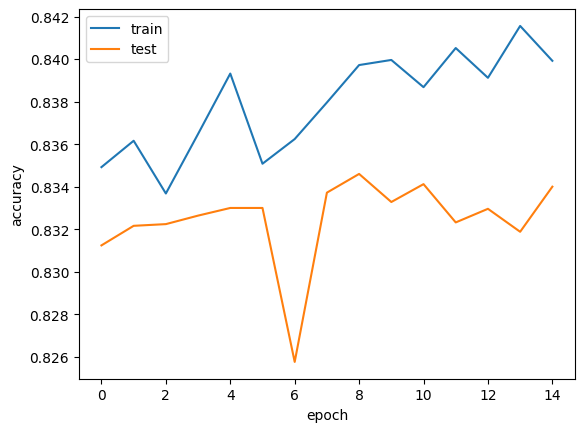

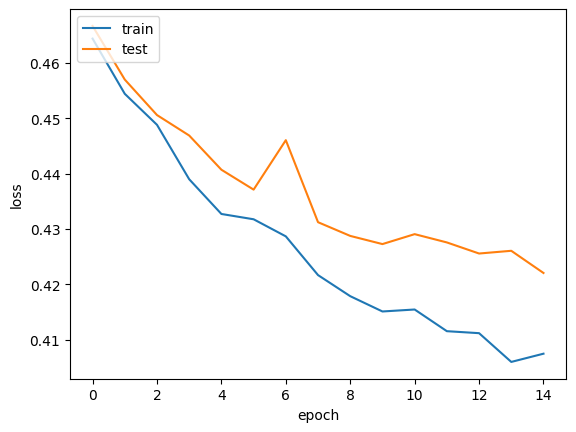

In [44]:
plot_history(l2reg_history,['accuracy','val_accuracy'])
plot_history(l2reg_history,['loss','val_loss'])

# Dropout

Dropout is an alternativeregularization techniques for neural networks. It consists of randomly “dropping out” (i.e. set to zero) a number of output features of the layer during training.

At test time, no units are dropped out, but the layer’s output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In [46]:
from keras.layers import Dropout
from keras import optimizers

Let’s add a couple of dropout layers in our IMDB network and see how it performs.


In [47]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu')(seq)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

dropout_model = Model(seq, x)

In [48]:
dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
dropout_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,121 (129.38 KB)

 Trainable params: 33,121 (129.38 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
dropout_history = dropout_model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 1
)

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5259 - loss: 0.7055 - val_accuracy: 0.7245 - val_loss: 0.6442
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6464 - loss: 0.6273 - val_accuracy: 0.7926 - val_loss: 0.4905
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7513 - loss: 0.5217 - val_accuracy: 0.8198 - val_loss: 0.4172
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7918 - loss: 0.4639 - val_accuracy: 0.8270 - val_loss: 0.3951
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8073 - loss: 0.4385 - val_accuracy: 0.8281 - val_loss: 0.3846


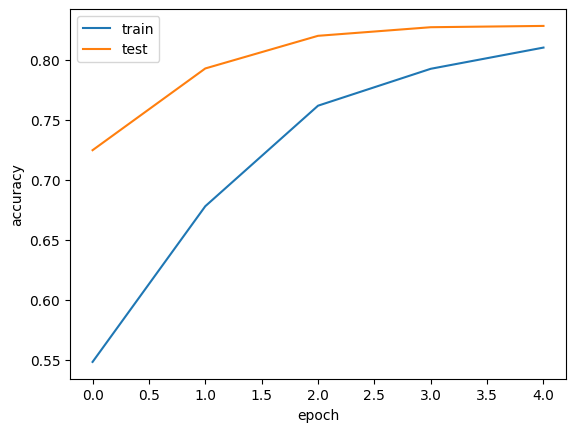

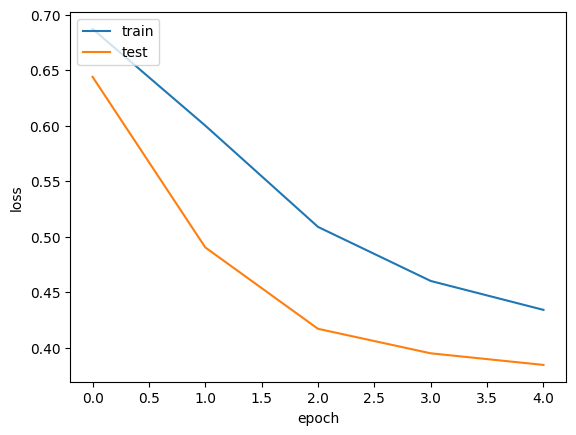

In [51]:
plot_history(dropout_history,['accuracy','val_accuracy'])
plot_history(dropout_history,['loss','val_loss'])

In [63]:
seq = Input(shape=(num_words,))#bs,500
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(seq)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

mixed_model = Model(seq, x)

In [64]:
adam = optimizers.Adam(learning_rate=0.001)
mixed_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
mixed_history = mixed_model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 2
)

Epoch 1/5
49/49 - 3s - 52ms/step - accuracy: 0.5777 - loss: 1.1956 - val_accuracy: 0.7548 - val_loss: 0.9518
Epoch 2/5
49/49 - 1s - 17ms/step - accuracy: 0.7201 - loss: 0.8350 - val_accuracy: 0.8113 - val_loss: 0.6620
Epoch 3/5
49/49 - 1s - 18ms/step - accuracy: 0.7894 - loss: 0.6494 - val_accuracy: 0.8264 - val_loss: 0.5516
Epoch 4/5
49/49 - 1s - 26ms/step - accuracy: 0.8093 - loss: 0.5688 - val_accuracy: 0.8276 - val_loss: 0.5082
Epoch 5/5
49/49 - 1s - 15ms/step - accuracy: 0.8180 - loss: 0.5281 - val_accuracy: 0.8300 - val_loss: 0.4823


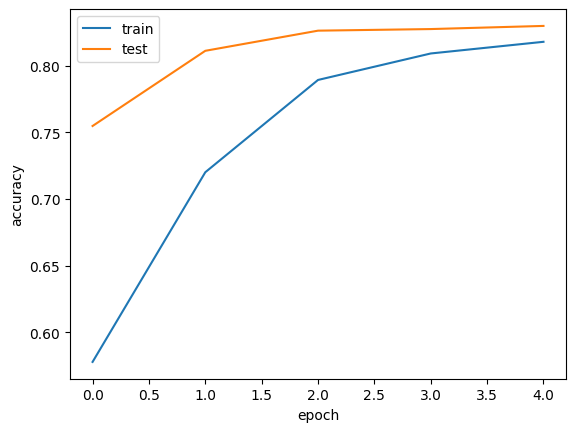

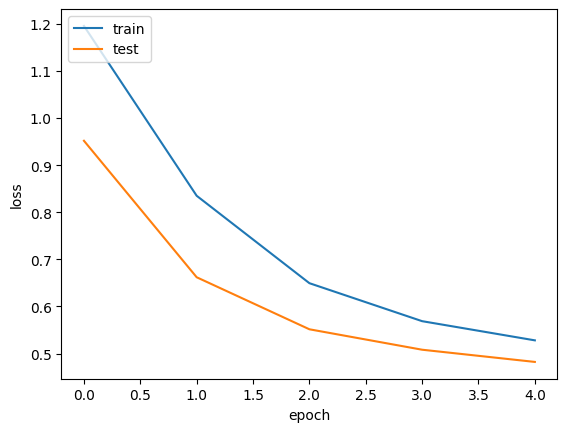

In [56]:
plot_history(mixed_history,['accuracy','val_accuracy'])
plot_history(mixed_history,['loss','val_loss'])

# Early stopping

Early stopping is a method that allows you to stop training as soon as the model performance stops improving on the validation dataset.

This requires that a validation set must be provided to the fit() function.

Early stopping can be simply implemented in keras using callbacks.
A callback is a function taht is called at specific stages of the training procedure: start/end of epochs, start end of minibatches, etc.

You can use callbacks to get a view on internal states and statistics of the model during training. A list of callbacks can be passed to the .fit() function using the keyword argument "callbacks".

In [67]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

chkpt = os.path.join(saveDir, 'Cifar10_to256.keras')

mixed_model.load_weights(chkpt)

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
cp_cb = ModelCheckpoint(filepath=chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [69]:
mixed_model.fit(x_train, y_train,
                batch_size=512, #batch_size,
                epochs= 20,
                verbose=2,
                validation_data=(x_test,y_test),
                callbacks=[es_cb, cp_cb],
                shuffle=True)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.43129, saving model to /content/saved_models/Cifar10_to256.keras
49/49 - 1s - 14ms/step - accuracy: 0.8406 - loss: 0.4364 - val_accuracy: 0.8319 - val_loss: 0.4313
Epoch 2/20

Epoch 2: val_loss improved from 0.43129 to 0.42940, saving model to /content/saved_models/Cifar10_to256.keras
49/49 - 1s - 28ms/step - accuracy: 0.8406 - loss: 0.4358 - val_accuracy: 0.8326 - val_loss: 0.4294
Epoch 3/20

Epoch 3: val_loss did not improve from 0.42940
49/49 - 1s - 24ms/step - accuracy: 0.8401 - loss: 0.4352 - val_accuracy: 0.8307 - val_loss: 0.4304
Epoch 4/20

Epoch 4: val_loss did not improve from 0.42940
49/49 - 1s - 21ms/step - accuracy: 0.8414 - loss: 0.4350 - val_accuracy: 0.8331 - val_loss: 0.4300
Epoch 5/20

Epoch 5: val_loss did not improve from 0.42940
49/49 - 1s - 15ms/step - accuracy: 0.8438 - loss: 0.4337 - val_accuracy: 0.8318 - val_loss: 0.4302
Epoch 5: early stopping


In [68]:
loss,acc = mixed_model.evaluate(x_test,y_test)
print("test loss = ", loss)
print("test accuracy = ", acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8333 - loss: 0.4292
test loss =  0.428847998380661
test accuracy =  0.8334000110626221
